In [1]:
from glob import glob

%matplotlib inline
from pylab import *
# import cv2
import rasterio as rio

rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)

import os,sys
from matplotlib import pyplot as plt
import numpy as np
# from scipy import misc
# import fiona
# from shapely.geometry import shape
# import shapely
# from rasterio.mask import mask
# from pyproj import Proj, transform


# add the unet helpers
sys.path.append('../../')
# from test_unet_helpers import *
# from unet_models import unet11_MS
from torchsat.models.segmentation.unet import UNetResNet

# torch stuff
import torch
from torch import nn
from torch.utils.data import Dataset

from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score

from collections import OrderedDict

# from torch.nn import functional as F
# from torchvision import models, datasets
# import torchvision
# from torchvision.transforms import ToTensor, Normalize, Compose
from utils import variable

In [2]:
class DG_GT_Dataset(Dataset):
    """Dataset class for ignition types (Y var)"""
    
    def __init__(self, data_dir, channels='all', img_transform=None, gt_transform=None):
        """ 
        Args:
            data_dir (string): the folder containing the image files
            channels (string): 'all', 'bgr', 'bgrn1', 'bgrn2'; band sets for DG imagery
            img_transform (callable, optional): Optional transform to  be applied to source image data
            gt_transform (callable, optional): Optional transform to  be applied to labeled image data
            x_var (iterable, optional): list of predictor variable names
            land_mask (string, optional): defines whether or not to return land mask
        """
        
        # some sanity checks
        assert os.path.exists(data_dir)
        
        self.gt_files = sorted(glob(data_dir + '/gt*.tif'))
        self.img_files = sorted(glob(data_dir + '/dg*.tif'))
        
        
        print(self.img_files[0])
        print(self.gt_files[0])
        
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        self.dg_bgr = [1,2,4]
        self.dg_bgrn1 = [1,2,4,6]
        self.dg_bgrn2 = [1,2,4,7]
        self.channels = channels
        
        assert len(self.img_files) == len(self.gt_files)
        
    
    def __getitem__(self, idx):
        
        """
            Files are organized as <var_type>_<year>_<month>_t<tileNumber>.tif, e.g., Arson_1992_1_t1
            A single dataset needs to be constructed for a given ignition type, year, month, and tile number
        """
        
        img_file = self.img_files[idx]
        gt_file = self.gt_files[idx]
        
        with rio.open(img_file) as src:
            img_arr = src.read()
            
        # check the channels
        if self.channels == 'bgr':
            img_arr = img_arr[self.dg_bgr, :, :]
        elif self.channels == 'bgrn1':
            img_arr = img_arr[self.dg_bgrn1, :, :]
        elif self.channels == 'bgrn2':
            img_arr = img_arr[self.dg_brgn2, :, :]
        else:
            pass
            
        with rio.open(gt_file) as src:
            gt_arr = src.read()

        if (self.img_transform is not None):
            return (self.img_transform(torch.from_numpy(img_arr)), 
                    self.gt_transform(torch.from_numpy(gt_arr)))   
        else:
            return (torch.from_numpy(img_arr), torch.from_numpy(gt_arr)) # return X, Y, Mask (Mask uses LandMask in X-var folder)
        
        
    def __len__(self):
        return len(self.img_files)

# Now that data is ready, set up the model and run through it

## some code for setting up the model and performance eval

In [3]:
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score

# need to change this to DICE loss!
#loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()


#cudnn.benchmark = True

# DO the same for pansharpened data

In [4]:
train_folder = r'D:\projects\RD\debug_IS_segmentation\tilesPS_d10000_512x512\train'
test_folder = r'D:\projects\RD\debug_IS_segmentation\tilesPS_d10000_512x512\test'
val_folder = r'D:\projects\RD\debug_IS_segmentation\tilesPS_d10000_512x512\val'

# ubuntu paths
train_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tilesPS_d10000_512x512/train'
test_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tilesPS_d10000_512x512/test'
val_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tilesPS_d10000_512x512/val'

# aws pathts
train_folder = '../../../tiles/kmeans3_split/tilesPS_d10000_512x512/train'
test_folder = '../../../tiles/kmeans3_split/tilesPS_d10000_512x512/test'
val_folder = '../../../tiles/kmeans3_split/tilesPS_d10000_512x512/val'

# load as 4 band
ps_train_ds = DG_GT_Dataset(train_folder, channels='bgr')
ps_test_ds = DG_GT_Dataset(test_folder, channels='bgr')
ps_val_ds = DG_GT_Dataset(val_folder, channels='bgr')

../../../tiles/kmeans3_split/tilesPS_d10000_512x512/train/dg_is_00000.tif
../../../tiles/kmeans3_split/tilesPS_d10000_512x512/train/gt_is_00000.tif
../../../tiles/kmeans3_split/tilesPS_d10000_512x512/test/dg_is_00731.tif
../../../tiles/kmeans3_split/tilesPS_d10000_512x512/test/gt_is_00731.tif
../../../tiles/kmeans3_split/tilesPS_d10000_512x512/val/dg_is_00500.tif
../../../tiles/kmeans3_split/tilesPS_d10000_512x512/val/gt_is_00500.tif


In [5]:
# RGB-NIR
#model_path = './files_PS_bgrn1/bgrn1_ps_ep75_step1575_b24.pt'
model_path = './files_MS_aug_bgr/jstars_bgr_ms_aug_ep500_step8000_b32.pt'

torch.cuda.empty_cache()

# load model for B-G-R-N1
ps_model = UNetResNet(encoder_depth=152, num_classes=1, in_channels=3, num_filters=32, dropout_2d=0.2,
                 pretrained=False, is_deconv=True)

# load on CPU
if os.path.exists(model_path):
    state_dict = torch.load(str(model_path), map_location='cpu')
    epoch = state_dict['epoch']
    step = state_dict['step']
    new_state_dict = OrderedDict()
    for k, v in state_dict['model'].items():
        name = k[7:] # remove 'module.' of dataparallel
        new_state_dict[name]=v

    ps_model.load_state_dict(new_state_dict)
    print('Restored model, epoch {}, step {:,}'.format(epoch, step))

ps_model.eval()

Restored model, epoch files_MS_aug_bgr/jstars_bgr_ms_aug_ep500_step8000_b32.pt, step 8,000


UNetResNet(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [6]:
all_tps = []
all_fps= []
maxes = []
mins = []
aucs = []
f1, f1_02, f1_04, f1_06, f1_08, f1_10 = [],[],[],[],[],[]
precisions = []
recalls = []
for ind in range(len(ps_val_ds)):
    test_im, test_target = ps_val_ds[ind]
    test_out = ps_model(variable(test_im.unsqueeze(0)))
    

    out = test_out.cpu().detach().numpy()[0][0]
    maxes.append(out.max())
    mins.append(out.min())
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_target.numpy().flatten(), out.flatten())
    aucs.append(roc_auc_score(test_target.numpy().flatten(), out.flatten()))
    all_tps.append(true_positive_rate)
    all_fps.append(false_positive_rate)
    f1.append(f1_score(test_target.numpy().flatten(), out.flatten() > 0, average='binary'))
    f1_02.append(f1_score(test_target.numpy().flatten(), out.flatten() > 0.2, average='binary'))
    f1_04.append(f1_score(test_target.numpy().flatten(), out.flatten() > 0.4, average='binary'))
    f1_06.append(f1_score(test_target.numpy().flatten(), out.flatten() > 0.6, average='binary'))
    f1_08.append(f1_score(test_target.numpy().flatten(), out.flatten() > 0.8, average='binary'))
    f1_10.append(f1_score(test_target.numpy().flatten(), out.flatten() > 1., average='binary'))
    precisions.append(precision_score(test_target.numpy().flatten(), out.flatten() > 0, average='binary'))
    recalls.append(recall_score(test_target.numpy().flatten(), out.flatten() > 0, average='binary'))

/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


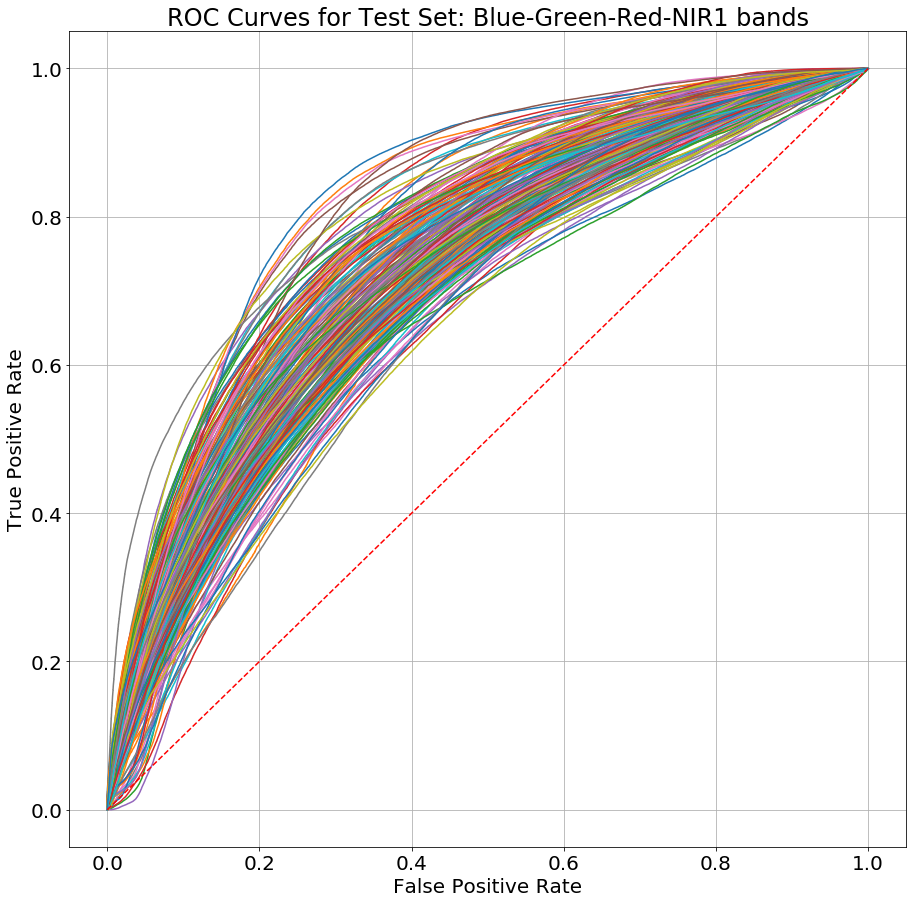

In [7]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)


plt.figure(figsize=(15,15))
for i in range(len(all_tps)):
    
    plt.plot(all_fps[i], all_tps[i])
    
plt.plot([0,1], [0,1], 'r--')
plt.title('ROC Curves for Test Set: Blue-Green-Red-NIR1 bands')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


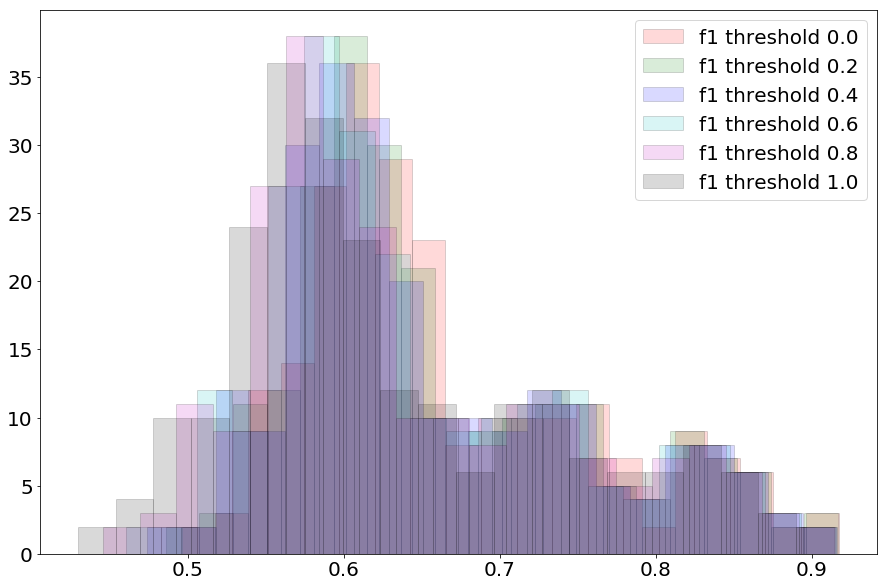

threshold 0.0: mean f1 0.666484272926027
threshold 0.2: mean f1 0.6611266325452555
threshold 0.4: mean f1 0.6548939196380965
threshold 0.6: mean f1 0.6475657355726699
threshold 0.8: mean f1 0.6391344847074085
threshold 1.0: mean f1 0.6296711954667912


In [8]:
# look at f1s
plt.figure(figsize=(15,10))
plt.hist(f1, bins=20, edgecolor='k', facecolor='r', alpha=0.15, label='f1 threshold 0.0')
plt.hist(f1_02, bins=20, edgecolor='k', facecolor='g', alpha=0.15, label='f1 threshold 0.2')
plt.hist(f1_04, bins=20, edgecolor='k', facecolor='b', alpha=0.15, label='f1 threshold 0.4')
plt.hist(f1_06, bins=20, edgecolor='k', facecolor='c', alpha=0.15, label='f1 threshold 0.6')
plt.hist(f1_08, bins=20, edgecolor='k', facecolor='m', alpha=0.15, label='f1 threshold 0.8')
plt.hist(f1_10, bins=20, edgecolor='k', facecolor='k', alpha=0.15, label='f1 threshold 1.0')
plt.legend()
plt.show()

print(f'threshold 0.0: mean f1 {np.mean(f1)}')
print(f'threshold 0.2: mean f1 {np.mean(f1_02)}')
print(f'threshold 0.4: mean f1 {np.mean(f1_04)}')
print(f'threshold 0.6: mean f1 {np.mean(f1_06)}')
print(f'threshold 0.8: mean f1 {np.mean(f1_08)}')
print(f'threshold 1.0: mean f1 {np.mean(f1_10)}')

/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


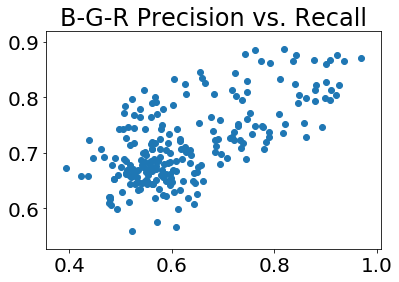

mAP: 0.7154572628337335
mAR: 0.6301631608835548


In [9]:
plt.scatter(recalls, precisions)
plt.title('B-G-R Precision vs. Recall')
plt.show()

print(f'mAP: {np.mean(precisions)}')
print(f'mAR: {np.mean(recalls)}')

/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


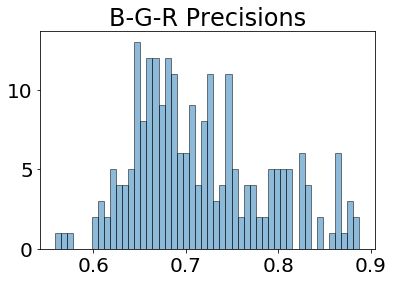

min B-G-R precision: 0.5587505487583745
mean B-G-R precision: 0.7154572628337335
max B-G-R precision: 0.8874894278464809


In [10]:
plt.hist(precisions, bins=50, alpha=0.5, edgecolor='k')
plt.title("B-G-R Precisions")
plt.show()
print(f'min B-G-R precision: {min(precisions)}')
print(f'mean B-G-R precision: {mean(precisions)}')
print(f'max B-G-R precision: {max(precisions)}')

/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


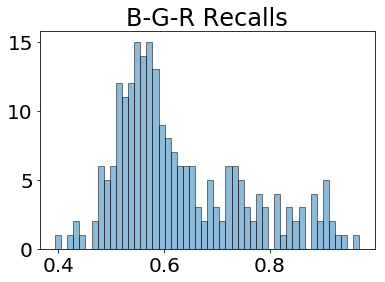

min B-G-R recall: 0.3935752937786174
mean B-G-R recall: 0.6301631608835548
max B-G-R recall: 0.9693790642025714


In [11]:
plt.hist(recalls, bins=50, alpha=0.5, edgecolor='k')
plt.title("B-G-R Recalls")
plt.show()
print(f'min B-G-R recall: {min(recalls)}')
print(f'mean B-G-R recall: {mean(recalls)}')
print(f'max B-G-R recall: {max(recalls)}')

/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


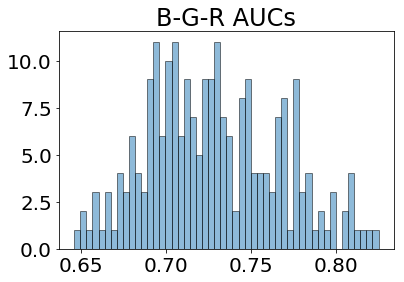

min B-G-R AUC: 0.6457590208176128
mean B-G-R AUC: 0.7279527340243898
max B-G-R AUC: 0.8250410275026065


In [12]:
plt.hist(aucs, bins=50, alpha=0.5, edgecolor='k')
plt.title("B-G-R AUCs")
plt.show()
print(f'min B-G-R AUC: {min(aucs)}')
print(f'mean B-G-R AUC: {mean(aucs)}')
print(f'max B-G-R AUC: {max(aucs)}')

/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


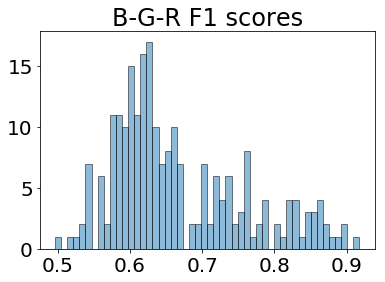

min B-G-R F1: 0.4965912189800928
mean B-G-R F1: 0.666484272926027
max B-G-R F1: 0.9174432440962345


In [13]:
plt.hist(f1, bins=50, alpha=0.5, edgecolor='k')
plt.title("B-G-R F1 scores")
plt.show()
print(f'min B-G-R F1: {min(f1)}')
print(f'mean B-G-R F1: {mean(f1)}')
print(f'max B-G-R F1: {max(f1)}')

## find the lowest, median, and highest f1 score. Plot the images


In [14]:
low_pos = np.argmin(f1)
high_pos = np.argmax(f1)
med_pos = np.where(np.array(f1) == np.median(f1))[0][0]
samples = (low_pos, med_pos, high_pos)

/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


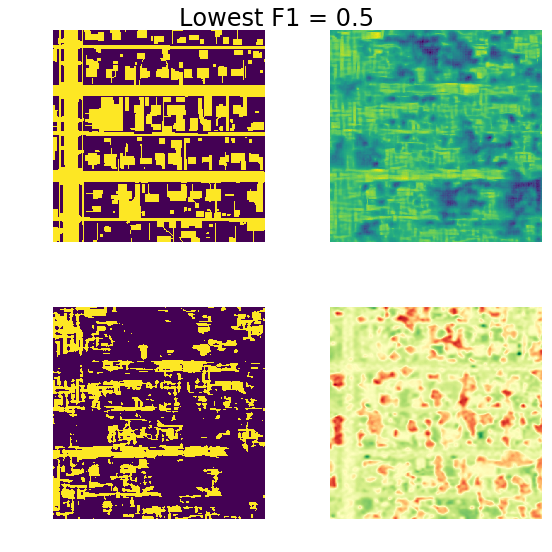

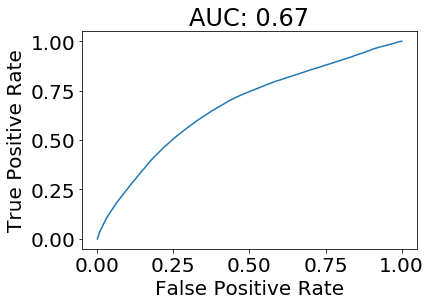

**************************************************************************************************************


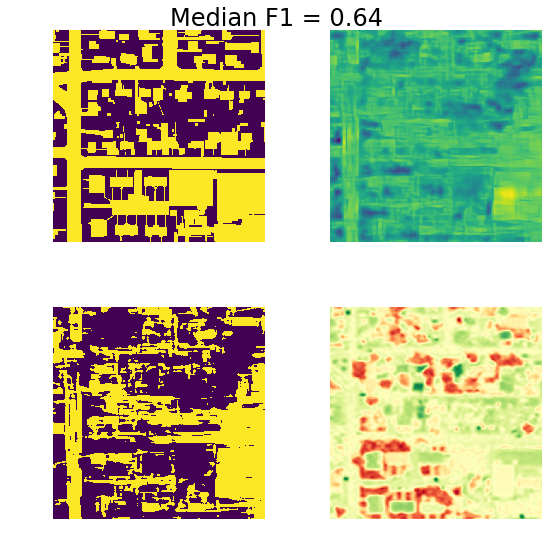

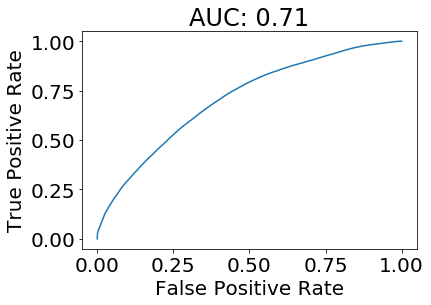

**************************************************************************************************************


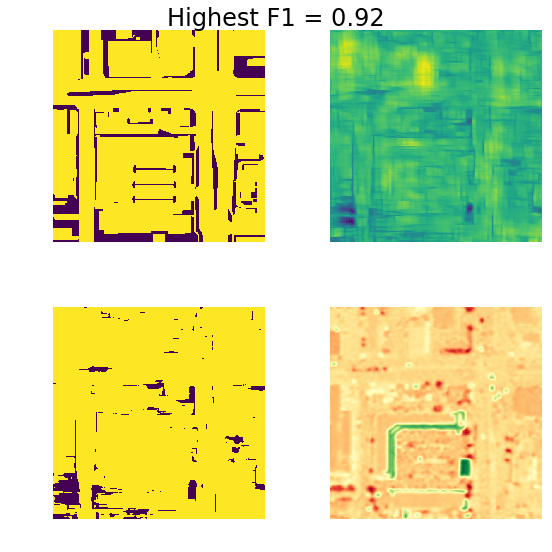

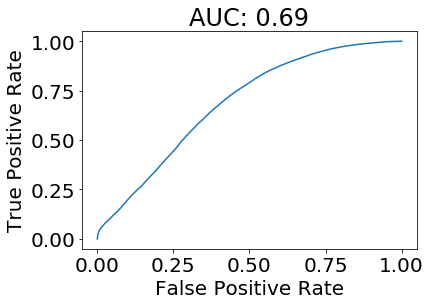

**************************************************************************************************************


In [15]:
for i,s in zip(('Lowest', 'Median', 'Highest'), samples):
    test_im, test_target = ps_val_ds[s]
    test_out = ps_model(variable(test_im.unsqueeze(0)))
    
    # plot the image
    fig, ax = plt.subplots(2,2, figsize=(8,8))
    ax[0,0].imshow(test_target.numpy()[0])
    ax[0,0].axis('off')

    out = test_out.cpu().detach().numpy()[0][0]
    ax[0,1].imshow(out)
    ax[0,1].axis('off')

    ax[1,0].imshow(out>0)
    ax[1,0].axis('off')
    
    # plot NDVI
    im_arr = test_im.cpu().detach().numpy()
    ndvi = (im_arr[-1] - im_arr[-2]) / (im_arr[-1] + im_arr[-2])
    ax[1,1].imshow(ndvi, interpolation='nearest', cmap='RdYlGn')    
    ax[1,1].axis('off')
    
    plt.suptitle('{0} F1 = {1:0.2}'.format(i, f1[s]))
    plt.tight_layout()
    plt.show()
    
    # plot the ROC curve
    plt.plot(all_fps[s], all_tps[s])
    plt.title('AUC: {0:0.2f}'.format(aucs[s]))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    print('**************************************************************************************************************')

In [16]:
samples

(129, 131, 61)